In [0]:
%%shell

mkdir /root/.kaggle
mv /content/kaggle.json ~/.kaggle/kaggle.json
chmod 600 /root/.kaggle/kaggle.json
kaggle datasets download -d datamunge/sign-language-mnist
unzip /content/sign-language-mnist.zip -d data/
rm /content/sign-language-mnist.zip
rm -r /content/data/sign_mnist_test
rm -r /content/data/sign_mnist_train
rm -r /content/data/amer_sign2.png
rm -r /content/data/amer_sign3.png
rm -r /content/data/american_sign_language.PNG

 91% 57.0M/62.6M [00:01<00:00, 33.3MB/s]
100% 62.6M/62.6M [00:01<00:00, 56.2MB/s]
Archive:  /content/sign-language-mnist.zip
  inflating: data/amer_sign2.png     
  inflating: data/amer_sign3.png     
  inflating: data/american_sign_language.PNG  
  inflating: data/sign_mnist_test.csv  
  inflating: data/sign_mnist_test/sign_mnist_test.csv  
  inflating: data/sign_mnist_train.csv  
  inflating: data/sign_mnist_train/sign_mnist_train.csv  


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from pathlib import Path

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import models
from torch.utils.data import Dataset
from torch.utils.data import SubsetRandomSampler
from torch.utils.data import DataLoader

In [0]:
path = Path('/content/data')
EPOCHS = 5
PRINT = 300

In [0]:
train = pd.read_csv(path/'sign_mnist_train.csv')
train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,156,158,160,163,165,159,166,168,170,170,171,171,171,172,171,171,170,170,169,111,121,129,135,141,144,148,151,154,157,160,...,205,206,206,207,207,206,206,204,205,204,203,202,142,151,160,172,196,188,188,190,135,96,86,77,77,79,176,205,207,207,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,157,158,156,154,154,153,152,151,149,149,148,147,146,144,142,143,138,92,108,158,159,159,159,160,160,160,160,160,160,160,...,100,78,120,157,168,107,99,121,133,97,95,120,135,116,95,79,69,86,139,173,200,185,175,198,124,118,94,140,133,84,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,186,185,185,185,184,184,184,181,181,179,179,179,178,178,109,52,66,77,83,188,189,189,188,188,189,188,188,188,188,187,...,203,204,203,201,200,200,199,198,196,195,194,193,198,166,132,114,89,74,79,77,74,78,132,188,210,209,206,205,204,203,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,211,209,207,208,207,206,203,202,201,200,198,197,195,192,197,171,51,52,54,212,213,215,215,212,212,213,212,212,211,211,...,247,242,233,231,230,229,227,225,223,221,220,216,58,51,49,50,57,60,17,15,18,17,19,1,159,255,237,239,237,236,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,186,188,189,189,190,191,189,190,190,187,190,192,193,191,191,192,192,194,194,166,169,172,174,177,180,182,185,186,187,190,...,90,77,88,117,123,127,129,134,145,152,156,179,105,106,105,104,104,104,175,199,178,152,136,130,136,150,118,92,85,76,92,105,105,108,133,163,157,163,164,179


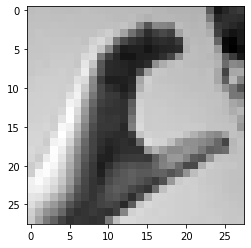

In [0]:
sample_image = train.loc[2][1:].values.reshape(28, 28)
plt.imshow(sample_image, cmap='gray')

In [0]:
class MNIST(Dataset):

    def __init__(self, train):
        self.labels = train['label'].values
        self.imgs = train.drop('label', axis=1).values

    def __getitem__(self, idx):
        label = self.labels[idx]
        image = self.imgs[idx].reshape(1, 28, 28)
        return torch.as_tensor(image, dtype=torch.float32), torch.tensor(label)

    def __len__(self):
        return len(self.labels)

In [0]:
data = MNIST(train)
labels = data.labels
train_idx, valid_idx = train_test_split(np.arange(len(labels)), test_size=0.15, shuffle=True, stratify=labels)

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)


train_loader = DataLoader(data, batch_size=32, sampler=train_sampler)
valid_loader = DataLoader(data, batch_size=32, sampler=valid_sampler)

In [0]:
class model(nn.Module):

    def __init__(self):
        super(model, self).__init__()

        self.conv1 = nn.Conv2d(1, 5, 3)
        self.conv2 = nn.Conv2d(5, 15, 3)
        self.conv3 = nn.Conv2d(15, 25, 3)
        self.pool = nn.MaxPool2d(2)

        self.fc1 = nn.Linear(25, 160)
        self.fc2 = nn.Linear(160, 64)
        self.fc3 = nn.Linear(64, 25)

    def forward(self, x):

        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        x = x.view(-1, 25)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

model = model()
model.to('cuda')
model

model(
  (conv1): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(5, 15, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(15, 25, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=25, out_features=160, bias=True)
  (fc2): Linear(in_features=160, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=25, bias=True)
)

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [0]:
def validation(model, valid_loader, criterion):
    loss = 0
    acc = 0

    for img, labels in iter(valid_loader):

        img, labels = img.to('cuda'), labels.to('cuda')
        output = model.forward(img)
        loss += criterion(output, labels).item()
        prob = torch.exp(output)
        eq = (labels.data == prob.max(dim=1)[1])
        acc += eq.type(torch.FloatTensor).mean()

    return loss/len(valid_loader), acc/len(valid_loader)

In [0]:
def training():
    steps = 0
    global EPOCHS
    global PRINT

    for e in range(EPOCHS):
        model.train()
        run_loss = 0

        for img, labels in iter(train_loader):
            
            steps += 1
            img, labels = img.to('cuda'), labels.to('cuda')
            
            optimizer.zero_grad()
            
            output = model(img)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            run_loss += loss.item()
            
            if steps%PRINT == 0:
                model.eval()

                with torch.no_grad():
                    val_loss, val_acc = validation(model, valid_loader, criterion)
                
                print(f"Epoch : {e+1}/{EPOCHS}, Training Loss : {run_loss/PRINT:.3f}, Validation Loss : {val_loss:.3f}, Validation Acc : {val_acc.item():.3f}")

            run_loss = 0
            model.train()

In [0]:
training()

Epoch : 1/5, Training Loss : 0.004, Validation Loss : 1.302, Validation Acc : 0.563
Epoch : 1/5, Training Loss : 0.003, Validation Loss : 0.728, Validation Acc : 0.752
Epoch : 2/5, Training Loss : 0.001, Validation Loss : 0.369, Validation Acc : 0.877
Epoch : 2/5, Training Loss : 0.001, Validation Loss : 0.235, Validation Acc : 0.915
Epoch : 3/5, Training Loss : 0.000, Validation Loss : 0.132, Validation Acc : 0.96
Epoch : 3/5, Training Loss : 0.000, Validation Loss : 0.199, Validation Acc : 0.932
Epoch : 3/5, Training Loss : 0.000, Validation Loss : 0.141, Validation Acc : 0.95
Epoch : 4/5, Training Loss : 0.000, Validation Loss : 0.071, Validation Acc : 0.981
Epoch : 4/5, Training Loss : 0.000, Validation Loss : 0.068, Validation Acc : 0.977
Epoch : 5/5, Training Loss : 0.000, Validation Loss : 0.070, Validation Acc : 0.975
Epoch : 5/5, Training Loss : 0.000, Validation Loss : 0.077, Validation Acc : 0.976
Epoch : 5/5, Training Loss : 0.000, Validation Loss : 0.020, Validation Acc : 

In [0]:
torch.save(model.state_dict(), '/content/Sign_Language.pt')

In [0]:
model.load_state_dict(torch.load('/content/Sign_Language.pt'))

<All keys matched successfully>